# Практическая работа №6
## Тема: Кластеризация
Выполнила Фонград Анастасия КИ21-16/1б

In [89]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.datasets import load_wine
from sklearn.cluster import AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, homogeneity_score, \
    completeness_score, v_measure_score, silhouette_score, accuracy_score

warnings.filterwarnings('ignore')

In [104]:
df_w = load_wine(as_frame=True).frame
x, y = df_w.drop("target", axis=1), df_w["target"]
df_w

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,2
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,2
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,2
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,2


In [95]:
def plot_pca(x, y, c_centers=None, title=None):
    """

    :param x:
    :param y:
    :param c_centers:
    :param title:
    :return:
    """
    plt.set_cmap('gist_rainbow')
    pca = PCA(n_components=2, random_state=42)
    x_pca = pca.fit_transform(x)
    plt.scatter(x_pca[:, 0], x_pca[:, 1], c=y)
    plt.xlabel("Первый главный признак")
    plt.ylabel("Второй главный признак")
    if title is not None:
        plt.title(title)
    if c_centers is not None:
        c_centers = pca.transform(c_centers)
        plt.scatter(c_centers[:, 0], c_centers[:, 1],
                    c=np.arange(c_centers.shape[0]), marker="+", s=300)
    plt.show()

In [101]:
def count_scores(x, y, y_pred):
    """

    :param x:
    :param y:
    :param y_pred:
    :return:
    """
    return pd.Series({
        'Adjusted Rand Index': adjusted_rand_score(y, y_pred),
        'Adjusted Mutual Information': adjusted_mutual_info_score(y, y_pred),
        'Homogeneity Score': homogeneity_score(y, y_pred),
        'Completeness Score': completeness_score(y, y_pred),
        'V-Measure Score': v_measure_score(y, y_pred),
        'Silhouette Score': silhouette_score(x, y_pred),
        'Accuracy': (accuracy := accuracy_score(y, y_pred)),
        'Mistake Rate': 1 - accuracy
    })

## Визуализация исходных данных

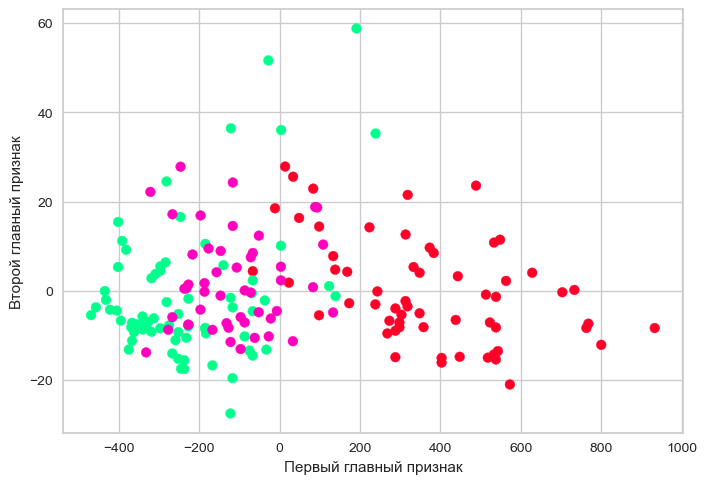

In [96]:
plot_pca(x, y)

## Оценка и визуализация K-means

3


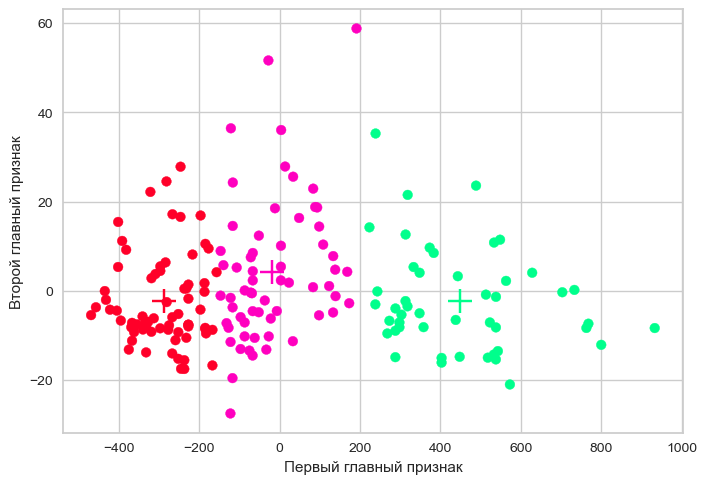

Adjusted Rand Index            0.371114
Adjusted Mutual Information    0.422687
Homogeneity Score              0.428812
Completeness Score             0.428701
V-Measure Score                0.428757
Silhouette Score               0.571138
Accuracy                       0.168539
Mistake Rate                   0.831461
dtype: float64

In [103]:
cl_count = np.unique(y if isinstance(y, np.ndarray) else y.values).size
print(cl_count)
km = KMeans(n_clusters=cl_count, random_state=42).fit(x)
plot_pca(x, km.labels_, c_centers=km.cluster_centers_)
count_scores(x, y, km.labels_)

## Правило локтя

In [99]:
def elbow_rule(x, title="Elbow method"):
    visualizer = KElbowVisualizer(KMeans(random_state=42),
                                  param_grid={"n_clusters": range(1, 11)},
                                  title=title)
    visualizer.fit(x)
    visualizer.show()
    return visualizer.elbow_value_

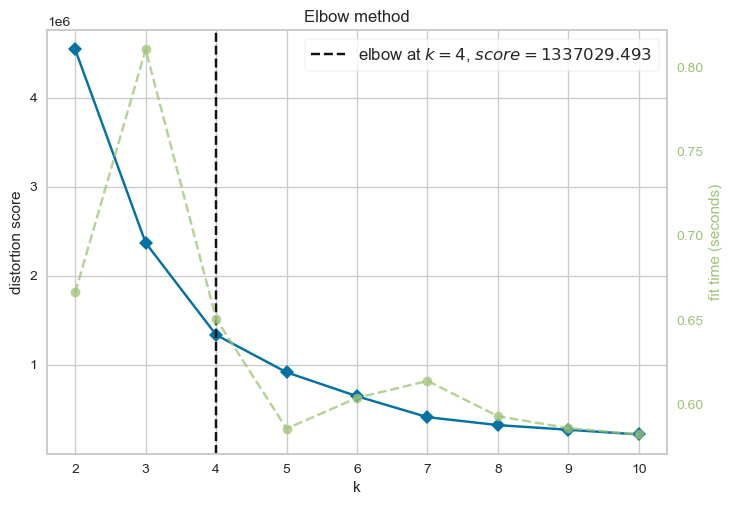

4

In [100]:
elbow_value = elbow_rule(x)

In [ ]:
cl_count = np.unique(y if isinstance(y, np.ndarray) else y.values).size
print(cl_count)
km = KMeans(n_clusters=cl_count, random_state=42).fit(x)
plot_pca(x, km.labels_, c_centers=km.cluster_centers_)
count_scores(x, y, km.labels_)